# Evaluating Gene Correlations - First heart field

In [17]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


from moscot.problems.time._lineage import TemporalProblem

In [18]:
Path="/home/mgander/Unrelated/moscotTime_Reproducibility/Data"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [19]:
ct='E8.25:First heart field'
i=11

ts0=ts[i]
ts1=ts[i+1]

In [20]:
gT=np.load(f"{Path}/TOME_transport_maps/{ts0}_{ct}_pull.npy", allow_pickle=True)
gM=np.load(f"{Path}/moscot_maps/{ts0}_{ct}_pull.npy", allow_pickle=True)

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into first heart field cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

TOME used the following genes to identify the first heart field cluster: Tbx5, Hcn4, Gata4.

In [26]:
D={}
D['PMID: 25274757']=['Nkx2-5', 'Gata4', 'Tbx5', 'Smarcd3']

# Isl1 and Tbx1 are SHF-driver genes!!!
#D['PMID: 22072574']=['Isl1', 'Tbx1', 'Tbx5']


D['PMID: 23457256']=['Eomes', 'Mesp1', 'Kdr', 'Pdgfra', 'Nkx2-5',  'Bmp2', 'Wnt1', 'Tbx5', 'Gata4', 
                     'Mef2c', 'Mef2a', 'Smarcd3']
D['PMID: 27194630']=['Tnnt2']
D['PMID: 23743334']=['Hcn4']
D['PMID: 18924235']=['Bmp4', 'Mef2c']
D['PMID: 30288953']=['Hand1', 'Hand2', 'Gata4', 'Mef2c', 'Tbx5']

D['PMID: 29440224']=['Nkx2-5', 'Tbx20', 'Foxf1','Pdgfra', 'Kdr', 
                     'Smarcd3', 'Foxa2',  'Bmp4', 'Hdac3', 'Nup155', 'Myod1']

D['PMID: 24123507']=['Irx4']
D['PMID: 17576928']=['Wnt2', 'Wnt7a', 'Wnt8a']
D['PMID: 29985326']=['Actc1']   #Actc1 is pan-cardiac marker
D['PMID: 33585493']=['Tbx20']
D['PMID: 20956536']=['Ccdc141']

D['PMID: 25183852']=['Tbx20', 'Hey2', 'Mycn', 'Nppa', 'Cx40', 'Cdkn1c', 'Bmp10']

# Chicken, so gotta be slighlty careful
#D['PMID: 14991725']=['Popdc2']



# Only in chamber myocardium: Nppa
# Only in AV canal: Tbx2

genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [22]:
adata=sc.read(f"{Path}/anndatas/scVI_anndatas/scvi_adata_{ts0}.h5ad")
adata.var.index=list(adata.var['gene_names'])

In [23]:
#genes=list(adata.var['gene_names'])

In [24]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)

In [14]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    if gene in [a for a in adata.var.index]:

        loc=adata.var.index.get_loc(gene)
        exp=adata.layers['scvi_normalized'][:,loc]
        #exp=adataS.X[:,loc]
        #exp=np.array(exp.todense()).T[0]
        
        if subset==True:
            wh=np.where(adata.obs['cell_state'].isin(['E8:Splanchnic mesoderm', 'E8:First heart field']))[0]
            #wh=np.where(adata.obs['cell_state'].isin(['E7.75:Splanchnic mesoderm', 'E7.75:First heart field']))[0]
            exp=exp[wh]
            gT2=gT[wh]
            gM2=gM[wh]
        else:
            gT2=gT.copy()
            gM2=gM.copy()


        (cor, p)=scipy.stats.spearmanr(exp, gT2)
        dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        (cor, p)=scipy.stats.spearmanr(exp, gM2)
        dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

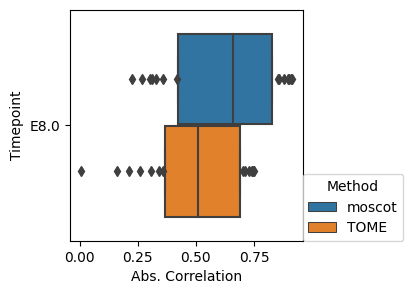

In [15]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
g=sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)
sns.move_legend(g,(1,0))

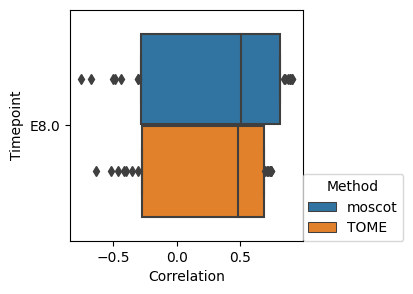

In [16]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
g=sns.boxplot(data=DF, x="Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)
sns.move_legend(g,(1,0))

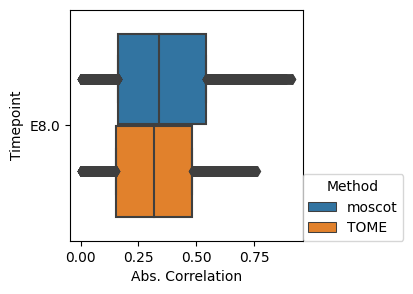

In [60]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
g=sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)
sns.move_legend(g,(1,0))

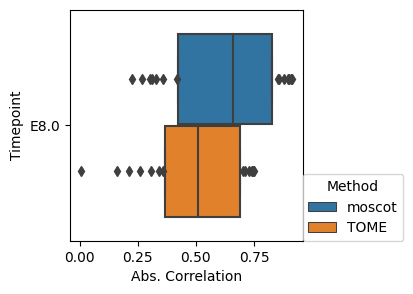

In [66]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
g=sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)
sns.move_legend(g,(1,0))

In [68]:
DF.to_pickle(f'{Path}/Correlations/{ts0}_FHF.npy')

In [70]:
DF.sort_values('Abs. Correlation')

,Timepoint,Gene,Method,Correlation,P-value,type,Abs. Correlation
33,E8.0,Hand2,TOME,-0.003396,9.152152e-01,Spearman,0.003396
3,E8.0,Pdgfra,TOME,-0.160423,4.164936e-07,Spearman,0.160423
45,E8.0,Wnt1,TOME,0.210768,2.362115e-11,Spearman,0.210768
50,E8.0,Kdr,moscot,-0.223067,1.426996e-12,Spearman,0.223067
25,E8.0,Bmp4,TOME,0.260362,1.001031e-16,Spearman,0.260362
44,E8.0,Wnt1,moscot,0.268095,1.122996e-17,Spearman,0.268095
12,E8.0,Foxa2,moscot,-0.302806,2.465477e-22,Spearman,0.302806
51,E8.0,Kdr,TOME,-0.308110,4.184561e-23,Spearman,0.308110
2,E8.0,Pdgfra,moscot,-0.309751,2.398937e-23,Spearman,0.309751
24,E8.0,Bmp4,moscot,0.327900,4.034816e-26,Spearman,0.327900


In [ ]:
Tnnt2
Tbx20
Cdkn1c
Ccdc141
Bmp2

In [ ]:
Tbx20

In [ ]:
Cdkn1c

In [ ]:
Ccdc141

In [72]:
DFs=DF[DF['Correlation']>0]

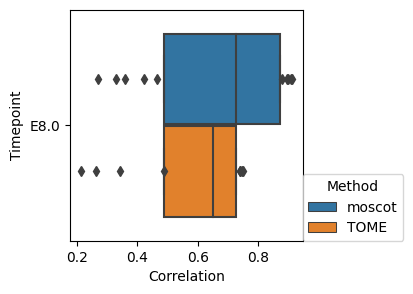

In [73]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
g=sns.boxplot(data=DFs, x="Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)
sns.move_legend(g,(1,0))